In [2]:
import os
import requests
import tqdm
import h5py
import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
import gc

In [3]:
baseUrl = 'http://www.illustris-project.org/api/'
headers = {"api-key":"f96eabbae6f336408a63f875f8cce22f"}

In [4]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

In [5]:
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed

In [6]:
cat = ascii.read('illustris_data/simulation_input_data_lzk.txt')

# sublink download

## download address

In [58]:
#illustris addres
illustris = get(baseUrl)
illustris_1 = get(illustris['simulations'][0]['url'])
sublink = get(illustris_1['files']['sublink'])

In [59]:
keys = ['DescendantID', 'SnapNum', 'SubfindID', 'SubhaloID', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassType', 'TreeID', 'SubhaloSFR']

In [62]:
for i in range(0,10):
    tree = get(sublink['files'][i])
    print(i)
    with h5py.File(f'illustris_data/tree_{i}.hdf5', 'w') as f:
        f.write(tree.content)
        

KeyboardInterrupt: 

In [61]:
sublink['files']

['http://www.illustris-project.org/api/Illustris-1/files/sublink.0.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.1.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.2.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.3.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.4.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.5.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.6.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.7.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.8.hdf5',
 'http://www.illustris-project.org/api/Illustris-1/files/sublink.9.hdf5']

## merge sublink files into 'tree_total.hdf5'

In [ ]:
#merge sublink files into 'tree_total.hdf5'
tree_total = {key:[] for key in keys}

for i in range(0, 10):
    name = f'tree_{i}.hdf5'
    
    f =  h5py.File(name, 'r') 
    for key in keys:
        tree_total[key].append(f[key][:])

In [ ]:
tree_total = {key: np.concatenate(tree_total[key], axis=0) for key in keys}

with h5py.File('illustris_data/tree_total.hdf5', 'w') as new:
    for key in keys:
        print(key)
        new.create_dataset(key, data = tree_total[key], dtype = tree_total[key].dtype.name, chunks = True, compression = 'gzip', compression_opts = 9)

## sublink indice: subhalo ID & corresponding descendant ID 'tree_total_new'

In [ ]:
# subhalo ID and correesponding descendantID
#first 6 files because there are no bhs beyond that

In [12]:
#sublink indices
#subhalo ID & corresponding descendant ID

descendent_id = []
subhalo_id = []

last_id = 0


for i in range(0,6):
    name = f'tree_{i}.hdf5'
    
    with h5py.File(name, 'r') as f:
        unique, ids = np.unique(f['TreeID'][:], return_index = True)
        length = len(unique)
        print(i)
        for j in range(length):
            
            subtract_ids = f['SubhaloID'][ids[j]] - last_id
            
            if j+1 == length:
                
                diff = len(f['SubhaloID'][:]) - ids[j]

                descendent_id.append((f['DescendantID'][ids[j]::] - subtract_ids) * (f['DescendantID'][ids[j]::] != -1) + -1*(f['DescendantID'][ids[j]::] == -1))
                subhalo_id.append(f['SubhaloID'][ids[j]::] - subtract_ids)
            else:

                diff = ids[j+1] - ids[j]
                descendent_id.append((f['DescendantID'][ids[j]:ids[j+1]] - subtract_ids) * (f['DescendantID'][ids[j]:ids[j+1]] != -1) + -1 *(f['DescendantID'][ids[j]:ids[j+1]] == -1))
                subhalo_id.append(f['SubhaloID'][ids[j]:ids[j+1]] - subtract_ids)
                
            last_id = last_id + diff
    
descendent_id = np.concatenate(descendent_id)
subhalo_id = np.concatenate(subhalo_id)
    

In [ ]:
name_new = f'illustris_data/tree_total_new.hdf5'
with h5py.File(name_new, 'w') as f:
    f.create_dataset('Descendant_index', data = descendent_id, dtype = descendent_id.dtype.name, chunks = True, compression = 'gzip', compression_opts = 9)
    f.create_dataset('Subhalo_index', data = subhalo_id, dtype = subhalo_id.dtype.name, chunks = True, compression = 'gzip', compression_opts = 9)
    

# snapshot & group catalog download

## download snapshot & groupcat header files

In [ ]:
#snapshot
path_list = [f'illustris_data/snap{x:d}' for x in range(30,136)]

for path in path_list:
    os.mkdir(path)

for j in range(30, 136):
    for i in range(0, 512):
        bhs = baseUrl + f'Illustris-1/files/snapshot-{j:d}.{i:d}.hdf5?bhs=all'
        result = get(bhs)
    
        filename = f'illustris_data/snap{j:d}/' + result.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(result.content)    

#groupcat header
path_list2 = [f'illustris_data/group{x:d}' for x in range(30,136)]
for path in path_list2:
    os.mkdir(path)

for j in range(30, 136):
    for i in range(0, 512):
        bhs = baseUrl + f'Illustris-1/files/groupcat-{j:d}.{i:d}.hdf5'
        result = get(bhs)
    
        filename = f'illustris_data/group{j:d}/' + result.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(result.content)

## bh particles in subhalo?: bh_subs_total

In [6]:
groupcat = h5py.File('illustris_data/groupcat_total_final.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [7]:
def init_bh_dict():
    h = 0.704
    bh_snap = {
                'BH_CumEgyInjection_QM': {'unit': r'$M_odot/(ckpc^2\ Gyr^2)$', 'dtype': 'f', 'cf': 1e10/(0.978**2*h), 'values': []},
                'BH_CumMassGrowth_QM': {'unit': r'$M_\odot$', 'dtype': 'f', 'cf': 1e10/h, 'values': []},
                'BH_Density': {'unit': r'$M_\odot/ckpc^3$', 'dtype': 'f', 'cf': 1e10*h**2, 'values': []},
                'BH_Hsml': {'unit': 'ckpc', 'dtype': 'f', 'cf': 1/h, 'values': []},
                'BH_Mass': {'unit': r'$M_\odot$', 'dtype': 'f', 'cf': 1e10/h, 'values': []},
                'BH_Mass_bubbles': {'unit': r'$M_\odot$', 'dtype': 'f', 'cf': 1e10/h, 'values': []},
                'BH_Mass_ini': {'unit': r'$M_\odot$', 'dtype': 'f', 'cf': 1e10/h, 'values': []},
                'BH_Mdot': {'unit': r'$M_\odot$/year', 'dtype': 'f', 'cf': 10.22, 'values': []},
                'BH_Pressure': {'unit': r'$M_odot/(ckpc\ Gyr^2)$', 'dtype': 'f', 'cf': 1e10*h**3/(0.978**2), 'values': []},
                'BH_Progs': {'unit': 'None', 'dtype': 'i', 'cf': 'None', 'values': []},
                'BH_U': {'unit': r'$(km/s)^2$', 'dtype': 'f', 'cf': 'None', 'values': []},
                'Coordinates': {'unit': 'ckpc', 'dtype': 'f', 'cf': 1/h, 'values': []},
                'HostHaloMass': {'unit': r'$M_\odot$', 'dtype': 'f', 'cf': 1e10/h, 'values': []},
                'Masses': {'unit': r'$M_\odot$', 'dtype': 'f', 'cf': 1e10/h, 'values': []},
                'NumTracers': {'unit': 'None', 'dtype': 'i', 'cf': 'None', 'values': []},
                'ParticleIDs': {'unit': 'None', 'dtype': 'long', 'cf': 'None', 'values': []},
                'Potential': {'unit': r'$(km/s)^2/a$', 'dtype': 'f', 'cf': 'None', 'values': []},
                'SubfindDensity': {'unit': r'$M_odot/ckpc^3$', 'dtype': 'f', 'cf': 1e10*h**2, 'values': []},
                'SubfindHsml': {'unit': 'ckpc', 'dtype': 'f', 'cf': 1/h, 'values': []},
                'SubfindVelDisp': {'unit': 'km/s', 'dtype': 'f', 'cf': 'None', 'values': []},
                'Velocities': {'unit': r'$km\sqrt(a)/s$', 'dtype': 'f', 'cf': 'None', 'values': []},
                'Snapshot': {'unit': 'None', 'dtype': 'i', 'cf': 'None', 'values': []},
                'Subhalo': {'unit': 'None', 'dtype': 'i', 'cf': 'None', 'values': []}
            }
    return bh_snap

In [12]:
### combine all black hole files in snap folder
snaps = range(30,136)
snaps = list(snaps)
snaps.remove(53)
snaps.remove(55)

In [15]:
# bh_snap

In [18]:
# for snap in snaps:
for snap in [127, 128]:
    
    print('snap: ' + str(snap) + ' ')  
    bh_snap = init_bh_dict()

    # groupcat['SubhaloID']
    snap_ids = np.where(groupcat['Snapshot'].value == snap)[0]
    sub_ids = groupcat['SubhaloID'][snap_ids] #subhalos in snap
    
    #calculate offset
    offset_snap = {}

    #example group catalog (for initialization)
    grp =  h5py.File(f'illustris_data/group{snap}/groups_{snap:03d}.0.hdf5', 'r')
    #offsets
    grp_offset = grp['Header'].attrs['FileOffsets_Subhalo']
    offset_snap['snapOffsets'] = grp['Header'].attrs['FileOffsets_Snap']
    
    #loadsubset                             
    #iteration: subhalo ids - find corresponding chunk
    for sub in range(len(sub_ids)):
     
        #target groups with this sub
        grp_file_offset = sub_ids[sub] - grp_offset
        chunk_num = np.max(np.where(grp_file_offset >= 0)) #corresponding chunk number
        offset = grp_file_offset[chunk_num]

        with h5py.File(f'illustris_data/group{snap}/groups_{snap:03d}.{chunk_num}.hdf5', 'r') as f:
            offset_snap['lenType'] = f['Subhalo']['SubhaloLenType'][offset, :]
            offset_snap['offsetType'] = f['Offsets']['Subhalo_SnapByType'][offset, :]

        #offset_snap => first result for one subhalo id


        #find corresponding info from snapdata (PartType5) / chunk iteration
        result = {}

        #header file info
        with h5py.File(f'illustris_data/snap{snap}/snap_{snap:03d}.0.hdf5') as f:
            header = dict(f['Header'].attrs.items())
            # # of particles for given types
            num_part = np.zeros(6, dtype = np.int64)       

            for i in range(6):
                num_part[i] = header['NumPart_Total'][i] | (header['NumPart_Total_HighWord'][i] << 32)
            
            offset_this_type = offset_snap['offsetType'][5] - offset_snap['snapOffsets'][5, :]

            file_num = np.max(np.where(offset_this_type >= 0))
            file_off = offset_this_type[file_num]
            # number of particles (PartType5)
            num_read = offset_snap['lenType'][5] #count

            result['count'] = num_read
            
            n = 1
            while 'PartType5' not in f:
                f = h5py.File(f'illustris_data/snap{snap}/snap_{snap:03d}.{n}.hdf5', 'r')
                n += 1
            

            fields = list(f['PartType5'].keys())

            for i, field in enumerate(fields):
                shape = list(f['PartType5'][field].shape)
                shape[0] = num_read

                dtype = f['PartType5'][field].dtype
                if dtype == np.float64: dtype = np.float32
                result[field] = np.zeros(shape, dtype = dtype)

        result_off = 0
        num_read_original = num_read

        while num_read:

            f = h5py.File(f'illustris_data/snap{snap}/snap_{snap:03d}.{file_num}.hdf5', 'r')
             
            if 'PartType5' not in f:
                f.close()
                file_num += 1
                file_off = 0
                continue
                                    
            num_f = f['Header'].attrs['NumPart_ThisFile'][5]
            num_read2 = num_read

            if file_off + num_read2 > num_f: #add next chunk
                num_read2 = num_f - file_off

            for i, field in enumerate(fields):
                result[field][result_off:result_off+num_read2] = f['PartType5'][field][file_off:file_off+num_read2]

            result_off += num_read2
            num_read -= num_read2
            file_num += 1
            file_off = 0

            f.close()

        if num_read_original != result_off:
            print('weird', end = ' ')

        if len(fields) == 1:
            result = result[fields[0]]

        result_len = len(result['ParticleIDs'][:])
        bh_snap['Subhalo']['values'].append(np.full((result_len,), sub_ids[sub], dtype = int))
        bh_snap['Snapshot']['values'].append(np.full((result_len,),snap, dtype = int))

        for field in fields:
            if field == 'Subhalo' or field == 'Snapshot':
                continue
            
            bh_snap[field]['values'].append(result[field])


    #readout to file snapshot
    fname = f'illustris_data/snap{snap}/bh_subs{snap}.hdf5'

    with h5py.File(fname, 'w') as f:
        for key in bh_snap.keys():
            file = np.concatenate(bh_snap[key]['values'], axis = 0)
            
            if bh_snap[key]['cf'] != 'None':
                file = file * bh_snap[key]['cf']
            
            
            dat = f.create_dataset(key, data = file, dtype = file.dtype.name, chunks = True, compression='gzip', compression_opts = 0)
            dat.attrs['unit'] = bh_snap[key]['unit']

    ex = np.concatenate(bh_snap[key]['values'], axis = 0)
    print(len(ex))

snap: 127 


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


32173
snap: 128 
32425


In [28]:
groupcat.keys()

<KeysViewHDF5 ['Snapshot', 'SubhaloCM', 'SubhaloID', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVelDisp', 'SubhaloWindMass']>

In [31]:
bhs_total = init_bh_dict()

for i in snaps:
    fname = f'illustris_data/snap{i}/bh_subs{i}.hdf5'
    with h5py.File(fname, 'r') as f:
        for key in f.keys():
            bhs_total[key]['values'].append(f[key][:])

In [32]:
for key in bhs_total.keys():
    final = np.concatenate(bhs_total[key]['values'], axis = 0)

In [34]:
checker = np.core.records.fromarrays([snaps, subs], dtype = dtype)
sort = np.argsort(checker, order = ('Snapshot', 'Subhalo'))

In [33]:
num_snaps = len(bhs_total['Subhalo']['values'])
dtype = [('Snapshot', np.dtype(np.uint64)), ('Subhalo', np.dtype(np.uint64))]

snaps = []
subs = []
sort = {key: [] for key in bhs_total.keys()}

for i in range(num_snaps):
    aa = bhs_total['Snapshot']['values'][i]
    bb = bhs_total['Subhalo']['values'][i]
    
    snaps = np.concatenate((snaps, aa))
    subs = np.concatenate((subs, bb))
    

In [35]:
with h5py.File('illustris_data/bh_subs_final.hdf5', 'w') as f:
    for key in bhs_total.keys():
        vals = np.concatenate(bhs_total[key]['values'])
        output = vals[sort]
        dset = f.create_dataset(key, data = output, dtype=output.dtype.name,chunks=True, compression='gzip', compression_opts=9)
        dset.attrs['unit'] = bhs_total[key]['unit']

In [67]:
f = h5py.File('illustris_data/bh_subs_final.hdf5')#2394824

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [67]:
# f = h5py.File('illustris_data/bh_subs_total.hdf5') #2398602 #duplicated bhs exist

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [69]:
f.keys()

<KeysViewHDF5 ['BH_CumEgyInjection_QM', 'BH_CumMassGrowth_QM', 'BH_Density', 'BH_Hsml', 'BH_Mass', 'BH_Mass_bubbles', 'BH_Mass_ini', 'BH_Mdot', 'BH_Pressure', 'BH_Progs', 'BH_U', 'Coordinates', 'HostHaloMass', 'Masses', 'NumTracers', 'ParticleIDs', 'Potential', 'Snapshot', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Subhalo', 'Velocities']>

In [71]:
f.close()

## download group catalog files

In [24]:
#final group catalog 
snap_list = list(range(30, 136))
snap_list.remove(53)
snap_list.remove(55)

In [25]:
keys = ['SubhaloLenType', 'SubhaloCM', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVelDisp', 'SubhaloWindMass']
keys_all = ['SubhaloID', 'Snapshot'] + keys

In [31]:
for num in snap_list:
    subhalos_blackhole = { }
    print(num)
    for key in keys:
        key_url = f'http://www.illustris-project.org/api/Illustris-1/files/groupcat-{num}?Subhalo={key}'
    
        print(key)
        sub = get(key_url)
    
        filename = f'illustris_data/group{num}_{key}.hdf6'
        with open(filename, 'wb') as f:
            f.write(sub.content)
    
    
        with h5py.File(filename, 'r') as f:
            if key == keys[0]:
                sub_temp = f['Subhalo'][key]
                
                #pick subhalos with blackholes in them
                sub_bhs = np.where(sub_temp[:, 5] > 0)[0]
            
                subhaloID = sub_bhs
                snaps = np.full((len(sub_bhs)), num)
            
                subhalos_blackhole['SubhaloID'] = subhaloID
                subhalos_blackhole['Snapshot'] = snaps
        
            subhalos_blackhole[key] = f['Subhalo'][key][:][subhaloID]        
    
    with h5py.File(f'illustris_data/groupcat_{num}.hdf5', 'w') as f:
        for key in keys_all:
            f.create_dataset(key, data = subhalos_blackhole[key], dtype=subhalos_blackhole[key].dtype.name, chunks=True, compression='gzip', compression_opts=9)

135
SubhaloLenType
SubhaloCM
SubhaloMassType
SubhaloPos
SubhaloSFR
SubhaloVelDisp
SubhaloWindMass


In [1]:
#merge group catalog files  into 'groupcat_total.hdf5'

In [36]:
group = {key:[] for key in keys_all}

for s in snap_list:
    print(s, end = ' ')
    filename = f'illustris_data/groupcat_{s}.hdf5'
    with h5py.File(filename, 'r') as f:
        for key in keys_all:
            
            group[key].append(f[key][:])

30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 54 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 

In [37]:
with h5py.File('illustris_data/groupcat_total_final.hdf5', 'w') as f:
    for key in keys_all:
        group[key] = np.concatenate(group[key])
        f.create_dataset(key, data=group[key], dtype=group[key].dtype.name, chunks=True, compression='gzip', compression_opts=9)

In [217]:
groupcat_total = h5py.File('illustris_data/groupcat_total.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [9]:
groupcat_total.keys() #2359299 bhs

<KeysViewHDF5 ['Snapshot', 'SubhaloCM', 'SubhaloID', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVelDisp', 'SubhaloWindMass']>

In [42]:
finals = h5py.File('illustris_data/groupcat_total_final.hdf5')
finals.close()

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


# particle ID

In [9]:
# ex = get('http://www.illustris-project.org/api/Illustris-1/files/blackhole_mergers.hdf5')

# filename = 'bh_merger.hdf5'
# with open(filename, 'wb') as f:
#     f.write(ex.content)

In [7]:
bh_mergers = h5py.File('illustris_data/blackhole_mergers.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [8]:
bh_mergers.keys()

<KeysViewHDF5 ['Header', 'details', 'id_in', 'id_out', 'mass_in', 'mass_out', 'snapshot', 'time', 'tree']>

In [9]:
#surviving bh after mergers 
mass_in = bh_mergers['mass_in'][:]
mass_out = bh_mergers['mass_out'][:]

time = bh_mergers['time'][:]
snap = bh_mergers['snapshot'][:]

total_mass = np.array([mass_in, mass_out]).T

id_in = bh_mergers['id_in'][:]
id_out = bh_mergers['id_out'][:]

In [10]:
n_bad = 0
change = []

for i in range(len(mass_in)):
    out_val = np.argmax(total_mass[i])
    
    if out_val == 0:
        n_bad += 1
        change.append((i, id_out[i], id_in[i], time[i], snap[i]))

dtype = [
    ('merger', '<i4'),
    ('id_remove', np.dtype('uint64')),
    ('id_keep', np.dtype('uint64')),
    ('time', '<f4'),
    ('snap', '<i4')
]

In [11]:
n_bad #11415

11415

In [13]:
change1 = np.array(change, dtype = dtype)

In [16]:
part_id = np.array([id_in, id_out]).T
time = np.array([time, time]).T

In [17]:
for i in range(len(change1)):
    ids_fix = (part_id == change1['id_remove'][i]) & (time > change1['time'][i])
    ids_switch = change1['merger'][i]
    
    if np.count_nonzero(ids_fix) > 0:
        part_id[ids_fix] = change1['id_keep'][i]
        
    part_id[ids_switch][0] = change1['id_remove'][i]
    part_id[ids_switch][1] = change1['id_keep'][i]
    
    trans_out_keep = total_mass[ids_switch][0]
    trans_in_remove = total_mass[ids_switch][1]
    
    #switch
    total_mass[ids_switch][0] = trans_in_remove
    total_mass[ids_switch][1] = trans_out_keep
    
    ids_fix = (
        (change1['id_keep'] == change1['id_remove'][i]) &
        (change1['time'] >= change1['time'][i])
        
    )
    
    change1['id_keep'][ids_fix] = change1['id_keep'][i]
    
    ids_fix = (
        (change1['id_remove'] == change1['id_remove'][i]) &
        (change1['time'] >= change1['time'][i])
        
    )
    
    change1['id_remove'][ids_fix] = change1['id_keep'][i]

In [18]:
len(change1)

11415

In [19]:
with h5py.File('illustris_data/blackhole_mergers.hdf5', 'a') as merge:

    for ind_in, ind_out in enumerate(['in', 'out']):
        key_id = f'id_{ind_out}_new'
        key_mass = f'mass_{ind_out}_new'
        key_list = [key_id, key_mass]
        var_list = [part_id, total_mass]
        
        for key, var in zip(key_list, var_list):
            if key in merge:
                del merge[key]
            merge[key]  = var[:, ind_in]

In [32]:
#update new ids in merger files 

In [20]:
with h5py.File('illustris_data/bh_subs_final.hdf5') as f:
    part_id_all = f['ParticleIDs'][:]
    snap_all = f['Snapshot'][:]

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [21]:
change2 = np.array(change, dtype = dtype)

In [22]:
for i in range(len(change2)):
    
    ids_fix = ((part_id_all == change2['id_remove'][i]) & (snap_all >= change2['snap'][i]))
    
    part_id_all[ids_fix] = change2['id_keep'][i]
    
    ids_fix = ((change2['id_keep'] == change2['id_remove'][i]) & (change2['time'] >= change2['time'][i]))
    change2['id_keep'][ids_fix] = change2['id_keep'][i]
    
    ids_fix = ((change2['id_remove'] == change2['id_remove'][i]) & (change2['time'] >= change2['id_keep'][i]))
    change2['id_remove'][ids_fix] = change2['id_keep'][i]

In [23]:
with h5py.File('illustris_data/bh_subs_final.hdf5', 'a') as f:
    key = 'ParticleIDs_new'
    
    if key in f:
        del f[key]
    
    f.create_dataset(key, data = part_id_all, dtype = part_id_all.dtype.name, chunks = True, compression = 'gzip', compression_opts = 9)

In [18]:
f = h5py.File('illustris_data/bh_subs_final.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [20]:
# f['ParticleIDs_new']
f.close()

# select mergers

## find bad bhs

In [21]:
#find bad mergers
# when a subhalo loses its black hole in a fly-by encounter and subsequently spawns a new black hole, the spawned black hole is considered bad
# f = h5py.File('illustris_data/bh_subs_total2.hdf5')
with h5py.File('illustris_data/bh_subs_final.hdf5') as f:
    part_id_new = f['ParticleIDs_new'][:]
    part_id_old = f['ParticleIDs'][:]
    snaps_all = f['Snapshot'][:]
    subhalos_all = f['Subhalo'][:]
    subid_raw_all = np.asarray(snaps_all*1e12 + subhalos_all, dtype = np.int64)
    bh_masses_all = f['BH_Mass'][:]

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


In [22]:
# black holes where the last time
#find the last time you find a unique id
ids_unique, ids = np.unique(part_id_new[::-1], return_index = True)
filter_ids = (snaps_all[::-1][ids] != 135)

subID_raw_filtered = np.asarray(snaps_all[::-1][ids][filter_ids]*1e12 + subhalos_all[::-1][ids][filter_ids], dtype = np.int64)

In [29]:
with h5py.File('illustris_data/tree_total2.hdf5') as tree:
#     get the raw IDs from sublink and sort them
    subID_raw_sublink = np.asarray(
    tree['SubfindID'][:310600757] + tree['SnapNum'][:310600757]*1e12,
    dtype = np.int64
    )

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [30]:
ids_sort = np.argsort(subID_raw_sublink)

#find the raw sub IDs for subhalos at the last snapshot the black holes exist.
final_subs_ids = ids_sort[np.searchsorted(subID_raw_sublink[ids_sort], subID_raw_filtered)]

In [31]:
#ids for subhalos at the last snapshot where the bhs exist
len(final_subs_ids) #24989 #18181 #24821 #whyyyy?? #24821

24821

In [37]:
tree = h5py.File('illustris_data/tree_total2.hdf5')
tree_new = h5py.File('illustris_data/tree_total_new.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [38]:
bad = []

for i, final_ids in enumerate(tqdm.tqdm(final_subs_ids, desc = 'Subhalo inds')):
    desc_ids = final_ids

    while desc_ids != -1:
        desc_ids = tree_new['Descendant_index'][desc_ids]

        #number of blackholes
        if tree['SubhaloLenType'][desc_ids][5] > 0:

            #subhalo:figure out which subhalo in all bhs catalog corresponds to this sub
            ids_sub = np.where(subid_raw_all == subID_raw_sublink[desc_ids])[0][0]

            #snap:: find all the snapshots that contain the black hole
            snaps_bh = snaps_all[(part_id_new == part_id_new[ids_sub])]

            #
            if snaps_bh[0] == tree['SnapNum'][desc_ids]:
                bad.append((part_id_new[ids_sub], bh_masses_all[ids_sub], tree['SnapNum'][desc_ids]))


Subhalo inds: 100%|██████████| 24821/24821 [3:47:40<00:00,  1.82it/s]  


In [39]:
len(bad)#3720 #1543 #2086

2086

In [40]:
len(final_subs_ids) #24989 #24821

24821

In [41]:
dtype = [('id', np.dtype(np.uint64)), ('mass', np.dtype(float)), ('snap', np.dtype(np.int32))]
bad_arr = np.asarray(bad, dtype = dtype)
np.savetxt('illustris_data/bad_bhs_final', bad_arr) #bad blackholes

## find good mergers

In [30]:
with h5py.File('illustris_data/bh_subs_final.hdf5') as f:
    #get the unique ides in the all bhs dataset, as well as their first appearence (index) and count of appearences (counts)

    unique_part_ids_new, index, counts = np.unique(f['ParticleIDs_new'][:][::-1],return_counts = True, return_index = True)
    ### REMOVING ALL BLACK HOLES THAT ONLY APPEAR FOR ONE SNAPSHOT IN THE FULL BH-ALL DATASET and that have mass less than 10^6. (The merger switch algoritm is not perfect, so we cut out any issues below 10^6) ###

    bad_add = np.where((counts == 1) & (f['BH_Mass'][:][::-1][index] > 1e6))[0]


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [32]:
bad_arr = np.genfromtxt('illustris_data/bad_bhs_final', dtype = None)

In [33]:
bad_ids = bad_arr[:, 0].astype(np.uint64)
bad_ids = np.unique(np.concatenate([bad_ids, unique_part_ids_new[bad_add]]))

In [71]:
#final good mergers
good = []

with h5py.File('illustris_data/blackhole_mergers.hdf5') as f:
    time = f['time'][:]
    mass_in_new = f['mass_in_new'][:]
    mass_out_new = f['mass_out_new'][:]
    id_in_new = f['id_in_new'][:]
    id_out_new = f['id_out_new'][:]

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


In [72]:
h = 0.704

In [73]:
for i in range(len(time)):
#     if mass_in_new[i] >= 1e6 and mass_out_new[i] >= 1e6:
    if mass_in_new[i]* 1e10/h >= 1e6 and mass_out_new[i]* 1e10/h >= 1e6:
        good.append(i)
        continue
    if id_in_new[i] not in bad_ids and id_out_new[i] not in bad_ids:
        
        #both constituent bhs are in the particle IDS
        if id_in_new[i] in unique_part_ids_new and id_out_new[i] in unique_part_ids_new:
            good.append(i)

In [74]:
len(good) #20351 #20348 #20184 + 7(considering the mass unit)

20191

In [37]:
np.savetxt('illustris_data/good_mergers', np.array([np.array(good)]).T)

# find subhalos to download

In [6]:
with h5py.File('illustris_data/blackhole_mergers.hdf5') as bh_mergers:
    print(bh_mergers.keys())
    id_in_new = bh_mergers['id_in_new'][:]
    id_out_new = bh_mergers['id_out_new'][:]
    merg_snap = bh_mergers['snapshot'][:]

<KeysViewHDF5 ['Header', 'details', 'id_in', 'id_in_new', 'id_out', 'id_out_new', 'mass_in', 'mass_in_new', 'mass_out', 'mass_out_new', 'snapshot', 'time', 'tree']>


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [7]:
with h5py.File('illustris_data/bh_subs_final.hdf5') as subs_bhs:
    all_arr = np.core.records.fromarrays([subs_bhs['ParticleIDs_new'][:], subs_bhs['Snapshot'][:], subs_bhs['Subhalo'][:]], names = 'id, snap, sub')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [8]:
sort_all = np.argsort(all_arr, order = ('snap', 'sub'))
all_arr = all_arr[sort_all]

In [9]:
with h5py.File('illustris_data/groupcat_total.hdf5') as sb:
    print(sb.keys())
    subID_raw_gc = np.asarray(sb['Snapshot'][:]*1e12 + sb['SubhaloID'][:], dtype = np.uint64)
    suhalolentype = sb['SubhaloLenType'][:]
    sort_gc = np.argsort(subID_raw_gc)

<KeysViewHDF5 ['Snapshot', 'SubhaloCM', 'SubhaloID', 'SubhaloLenType', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVelDisp', 'SubhaloWindMass']>


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [10]:
good = np.genfromtxt('illustris_data/good_mergers').astype(int)

In [11]:
len(good)

20184

In [12]:
set(cat['merger']) - set(good)

set()

In [14]:
len(all_arr)

2394824

In [1]:
subs_to_search = []
bads = []

for i, m in enumerate(tqdm.tqdm(good, desc = 'Goodmergers')):
    
    id_in = id_in_new[m]
    id_out = id_out_new[m]
    snap = merg_snap[m]
    
    #host galaxy post merger
    try:
        test = (all_arr['id'] == id_out) & (all_arr['snap'] == snap)
        ids_final = np.where(test)[0][0]
    except IndexError:
        print(f'{m}: no corresponding out host')
        bads.append(m)
        continue
    
    #avoid snap 53 and 55
    if snap-1 in [53, 55]:
        prev_snap = snap-2
    else:
        prev_snap = snap-1
    
    #prev_in2
    try:
        test = (all_arr['id'] == id_out) & (all_arr['snap'] == prev_snap)
        ids_prev_out = np.where(test)[0][0]
    except IndexError:
        print(f'{m}: no corresponding in2 host')
        bads.append(m)
        continue
     
    #prev_in1
    try:
        test = (all_arr['id'] == id_in) & (all_arr['snap'] == prev_snap)
        ids_prev_in = np.where(test)[0][0]
    except IndexError:
        print(f'{m}: no corresponding in1 host')
        bads.append(m)
        continue
    
    subs_to_search.append({'merger': m, 'final_out': ids_final, 'prev_out': ids_prev_out, 'prev_in': ids_prev_in})

NameError: name 'tqdm' is not defined

In [73]:
len(subs_to_search) #17196 / 18407
# subs_to_search

18407

In [74]:
subs_to_search = {key: [subs_to_search[i][key] for i in range(len(subs_to_search))] for key in subs_to_search[0].keys()}

In [75]:
subs_to_search = {key: np.asarray(subs_to_search[key], dtype = int) for key in subs_to_search}

In [76]:
len(subs_to_search['merger']) #19073 / 19074 / 17196

18407

In [77]:
snap_out = all_arr['snap'][np.asarray(subs_to_search['final_out'], dtype = int)]
sub_out = all_arr['sub'][np.asarray(subs_to_search['final_out'], dtype = int)]
subID_raw_mergers = np.asarray(snap_out*1e12 + sub_out, dtype = np.int64)


ids_final_gc = sort_gc[np.searchsorted(subID_raw_gc[sort_gc], subID_raw_mergers)]
suhalolentype = suhalolentype[ids_final_gc]

In [97]:
keep1 = np.where((suhalolentype[:,0] >= 80) & (suhalolentype[:,1] >= 300) & (suhalolentype[:,4] >= 80))[0]
subs_to_search = {key: subs_to_search[key][keep1] for key in subs_to_search}

In [98]:
len(subs_to_search['merger']) #18515 #16735

18407

In [53]:
which = {'final_out':3, 'prev_out':2, 'prev_in':1}

In [54]:
out = []

for key in ['final_out', 'prev_in', 'prev_out']:
    vals = subs_to_search[key]
    out.append(
        [subs_to_search['merger'],
         all_arr['snap'][vals],
         all_arr['sub'][vals],
         np.full(len(vals), which[key])]
    )

In [55]:
out = np.concatenate(out, axis = 1).T

dtype = [('m', np.dtype(int)), ('which', np.dtype(int)), ('snap', np.dtype(int)), ('sub', np.dtype(int))]

out = np.core.records.fromarrays([out[:, 0], out[:, 3], out[:, 1], out[:, 2]], dtype=dtype)
out = np.sort(out, order=('m', 'which', 'snap', 'sub'))

In [75]:
len(out)

50205

In [57]:
fname = 'illustris_data/snap_subs_final.hdf5'
header = ('which number is (3, final_out) (2, prev_out) (1, prev_in)'
                '\nmerger\twhich\tsnap\tsub')
np.savetxt(fname, out, fmt = '%i\t%i\t%i\t%i', header=header)

In [120]:
a = 9

In [121]:
snap_subs[a*3:a*3+3]

array([(9, 1, 43, 716), (9, 2, 43, 714), (9, 3, 44, 301)],
      dtype=[('merger', '<i8'), ('which', '<i8'), ('snap', '<i8'), ('sub', '<i8')])

# download subhalos

In [69]:
fname = 'illustris_data/snap_subs_final.hdf5'
snap_subs = np.genfromtxt(fname, skip_header = 1, names = True, dtype = None)

In [70]:
list1 = []
for i in range(len(snap_subs)):
    list1.append(str(snap_subs[i][2]) + '_'+ str(snap_subs[i][3]))

In [71]:
path = 'illustris_data/final/extra/'
file_list = os.listdir(path)

In [72]:
list2 = [x[7:-5] for x in file_list]

In [73]:
f_list = list(set(list1) - set(list2))

In [74]:
snaps = []
subs = []
for i in range(len(f_list)):
    snaps.append(int(f_list[i].split('_')[0]))
    subs.append(int(f_list[i].split('_')[1]))

In [76]:
# snaps

In [255]:
for i in range(len(snaps)):
#     which = row[1]
#     snap = row[2]
#     sub = row[3]
    print(i, end = ' ')
    cutout_request = {
        'bhs': 'all',
        'gas': 'Coordinates,Masses,Velocities,StarFormationRate',
        'stars': 'Coordinates,Masses,Velocities,GFM_StellarFormationTime',
        'dm': 'Coordinates,Velocities'
    }
    
    cutout = get(f'http://www.illustris-project.org/api/Illustris-1/snapshots/{snaps[i]}/subhalos/{subs[i]}/cutout.hdf5', cutout_request)
    
    path = f'illustris_data/final/extra/cutout_{snaps[i]}_{subs[i]}.hdf5'
    
    with open(path, 'wb') as f:
        f.write(cutout.content)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 

# final data

## density fit

In [11]:
fname = 'illustris_data/snap_subs_final.hdf5'
snap_subs = np.genfromtxt(fname, skip_header = 1, names = True, dtype = None)

In [12]:
len(snap_subs)

55545

In [13]:
with h5py.File('illustris_data/blackhole_mergers.hdf5') as f:
    merger_time = f['time'][:]

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [14]:
# with h5py.File('illustris_data/groupcat_total.hdf5') as f:
#     subs_gc = f['SubhaloID'][:]
#     snaps_gc = f['Snapshot'][:]
#     subhalo_cm_gc = f['SubhaloCM'][:]
groupcat = h5py.File('illustris_data/groupcat_total.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """


In [15]:
def fit_func(x, a, b):
    """
    Power law fit for the density profile
    """
    return a*x**-b

In [16]:
def density_profile(coord, masses, scale, sub_cm):
    
    radius = np.sqrt(np.sum((coord - sub_cm)**2, axis=1))*scale*1e3

    dtype = [('rad', np.dtype(float)), ('mass', np.dtype(float))]
    all_particles = np.core.records.fromarrays([radius, masses], dtype=dtype)

    all_particles = np.sort(all_particles, order=('rad',))

    extr = [all_particles['rad'][0]-1, all_particles['rad'][-1]+1]
    radial_bins_edges = np.logspace(*np.log10(extr), 100)

    bin_number_for_each_paricle = np.searchsorted(radial_bins_edges, all_particles['rad'])
    unique_bins, bin_count = np.unique(bin_number_for_each_paricle, return_counts=True)

#     inds_bins = np.where(bin_count >= 4)[0][0:8]

#     unique_bins = unique_bins[inds_bins]

#     radial_bins_inner_edges = radial_bins_edges[inds_bins]
#     radial_bins_outer_edges = radial_bins_edges[inds_bins+1]

#     radial_bin_centers = (radial_bins_outer_edges + radial_bins_inner_edges)/2.

#     volume_bin = 4/3.*np.pi*(radial_bins_outer_edges**3 - radial_bins_inner_edges**3)

#     density_bin = np.zeros(len(radial_bin_centers))

#     for i, bin in enumerate(unique_bins):

#         inds_bin = (bin_number_for_each_paricle == bin)
#         density_bin[i] = np.sum(all_particles['mass'][inds_bin])/volume_bin[i]

#     var, cov = curve_fit(fit_func, radial_bin_centers[0:8], density_bin[0:8], maxfev = 1000)
  
    return bin_count

In [17]:
def get_sub_index(snap, sub):
    
    ind = np.where((groupcat['Snapshot'][:] == snap) & (groupcat['SubhaloID'][:] == sub))[0]
    
#     sub_cm = groupcat['SubhaloCM'][ind]
    return ind

In [20]:
h = 0.704

In [23]:
errors = []
for i in range(10000, 11000):
    print(i, end = ' ')
    ind = 3 * i + 2
        
    data = snap_subs[ind]

    snap = data[2]
    sub = data[3]

    sub_index = get_sub_index(snap, sub)
    sub_cm = groupcat['SubhaloCM'][sub_index]

    f = h5py.File(f'illustris_data/final/extra/cutout_{snap}_{sub}.hdf5')

    scale_out = f['Header'].attrs['Time']


    #star density, type4
    stellar_mask = (f['PartType4']['GFM_StellarFormationTime'][:] >= 0.0) #star only, exclude wind ptls
    stellar_coord = f['PartType4']['Coordinates'][:][stellar_mask]
    stellar_masses = f['PartType4']['Masses'][:][stellar_mask]*1e10/h
    stellar_bc = density_profile(stellar_coord, stellar_masses, scale_out, sub_cm)

    try:
        bins = np.where(stellar_bc >= 4)[0][0:8]
    except IndexError:
        print('error')
        errors.append(ind)

    #dm density, type1
    dm_coord = f['PartType4']['Coordinates'][:]
    dm_masses = np.full(len(dm_coord[:],), 6.3e6)
    dm_bc = density_profile(dm_coord, dm_masses, scale_out, sub_cm)

    try:
        bins = np.where(dm_bc >= 4)[0][0:8]
    except IndexError:
        print('error')
        errors.append(ind)


    #gas density, type0
    gas_coord = f['PartType0']['Coordinates'][:]
    gas_masses = f['PartType0']['Masses'][:]*1e10/h
    gas_bc = density_profile(gas_coord, gas_masses, scale_out, sub_cm)

    try:
        bins = np.where(gas_bc >= 4)[0][0:8]
    except IndexError:
        print('error')
        errors.append(ind)


10000 

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


10001 10002 10003 10004 10005 10006 10007 10008 10009 10010 10011 10012 10013 10014 10015 10016 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10028 10029 10030 10031 10032 10033 10034 10035 10036 10037 10038 10039 10040 10041 10042 10043 10044 10045 10046 10047 10048 10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073 10074 10075 10076 10077 10078 10079 10080 10081 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10114 10115 10116 10117 10118 10119 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10143 10144 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10155 10156 10157 10158 10159 10160 10161 10162 10163 10164 10165 10166 1016

In [22]:
errors

[]

In [391]:
i

(0, 0)

# create final data

## data & path

In [ ]:
cat = ascii.read('simulation_input_data_lzk.txt')

In [ ]:
dat = ascii.read('illustris_data/data.txt')

In [ ]:
groupcat = h5py.File('illustris_data/groupcat_total.hdf5')

In [ ]:
mergers = h5py.File('blackhole_mergers.hdf5')

In [ ]:
fs = []

for i in range(len(cat)):
    n1 = 'cutout_'+str(cat['snap_prev_in'][i]) + '_' + str(cat['subhalo_prev_in'][i]) + '.hdf5'
    n2 = 'cutout_'+str(cat['snapshot_prev_out'][i]) + '_' + str(cat['subhalo_prev_out'][i])+ '.hdf5'
    n3 = 'cutout_'+str(cat['snapshot_fin_out'][i]) + '_' +str(cat['subhalo_fin_out'][i])+ '.hdf5'
    fs.append(n1)
    fs.append(n2)
    fs.append(n3)

In [ ]:
bh_in = []
bh_in2 = []
bh_out = [] #same bh id as bh_out

for i in range(len(cat)):
    n1 = 'cutout_'+str(cat['snap_prev_in'][i]) + '_' + str(cat['subhalo_prev_in'][i]) + '.hdf5'
    n2 = 'cutout_'+str(cat['snapshot_prev_out'][i]) + '_' + str(cat['subhalo_prev_out'][i])+ '.hdf5'
    n3 = 'cutout_'+str(cat['snapshot_fin_out'][i]) + '_' +str(cat['subhalo_fin_out'][i])+ '.hdf5'
    bh_in.append(n1)
    bh_in2.append(n2)
    bh_out.append(n3)

In [ ]:
path = 'illustris_data/final/extra/'
file_list = os.listdir(path)

## variables # funcs

In [373]:
h = 0.704

In [377]:
from scipy.optimize import curve_fit

In [ ]:
def density_profile(coord, masses, scale, sub_cm):
    
    radius = np.sqrt(np.sum((coord - sub_cm)**2, axis=1))*scale*1e3

    dtype = [('rad', np.dtype(float)), ('mass', np.dtype(float))]
    all_particles = np.core.records.fromarrays([radius, masses], dtype=dtype)

    all_particles = np.sort(all_particles, order=('rad',))

    extr = [all_particles['rad'][0]-1, all_particles['rad'][-1]+1]
    radial_bins_edges = np.logspace(*np.log10(extr), 100)

    bin_number_for_each_paricle = np.searchsorted(radial_bins_edges, all_particles['rad'])
    unique_bins, bin_count = np.unique(bin_number_for_each_paricle, return_counts=True)

    inds_bins = np.where(bin_count >= 4)[0][0:8]

    unique_bins = unique_bins[inds_bins]

    radial_bins_inner_edges = radial_bins_edges[inds_bins]
    radial_bins_outer_edges = radial_bins_edges[inds_bins+1]

    radial_bin_centers = (radial_bins_outer_edges + radial_bins_inner_edges)/2.

    volume_bin = 4/3.*np.pi*(radial_bins_outer_edges**3 - radial_bins_inner_edges**3)

    density_bin = np.zeros(len(radial_bin_centers))

    for i, bin in enumerate(unique_bins):

        inds_bin = (bin_number_for_each_paricle == bin)
        density_bin[i] = np.sum(all_particles['mass'][inds_bin])/volume_bin[i]

    var, cov = curve_fit(fit_func, radial_bin_centers[0:8], density_bin[0:8], maxfev = 1000)
  
    return var

In [ ]:
def fit_func(x, a, b):
    """
    Power law fit for the density profile
    """
    return a*x**-b

In [ ]:
def get_sub_index(snap, sub):
    
    ind = np.where((groupcat['Snapshot'][:] == snap) & (groupcat['SubhaloID'][:] == sub))[0]
    
#     sub_cm = groupcat['SubhaloCM'][ind]
    return ind

In [ ]:
def density_profile(coord, masses, scale, sub_cm):
    
    radius = np.sqrt(np.sum((coord - sub_cm)**2, axis=1))*scale*1e3

    dtype = [('rad', np.dtype(float)), ('mass', np.dtype(float))]
    all_particles = np.core.records.fromarrays([radius, masses], dtype=dtype)

    all_particles = np.sort(all_particles, order=('rad',))

    radial_bins_edges = np.logspace(np.log10(all_particles['rad'][0]-1), np.log10(all_particles['rad'][-1]+1), 100)

    bin_number_for_each_paricle = np.searchsorted(radial_bins_edges, all_particles['rad'])
    unique_bins, bin_count = np.unique(bin_number_for_each_paricle, return_counts=True)

    inds_bins = np.where(bin_count >= 4)[0][0:8]

    unique_bins = unique_bins[inds_bins]

    radial_bins_inner_edges = radial_bins_edges[inds_bins]
    radial_bins_outer_edges = radial_bins_edges[inds_bins+1]

    radial_bin_centers = (radial_bins_outer_edges + radial_bins_inner_edges)/2.

    volume_bin = 4/3.*np.pi*(radial_bins_outer_edges**3 - radial_bins_inner_edges**3)

    density_bin = np.zeros(len(radial_bin_centers))

    for i, bin in enumerate(unique_bins):

        inds_bin = np.where(bin_number_for_each_paricle == bin)[0]
        density_bin[i] = np.sum(all_particles['mass'][inds_bin])/volume_bin[i]

    var, cov = curve_fit(fit_func, radial_bin_centers[0:8], density_bin[0:8], maxfev = 1000)
#     var, cov = curve_fit(fit_func, radial_bin_centers[0:8], density_bin[0:8])
  
    return var

## final data

In [ ]:
list_redshift = []
list_separation = []

list_bh_id_in1 = []
list_bh_id_in2 = []
list_bh_id_out = []

list_snap_in1 = []
list_snap_in2 = []
list_snap_out = []

list_v_disp_in1 = []
list_v_disp_in2 = []
list_v_disp_out = []

list_bh_mass_in1 = []
list_bh_mass_in2 = []
list_bh_mass_out = []

list_bh_mdot_in1 = []
list_bh_mdot_in2 = []
list_bh_mdot_out = []

list_stellar_mass_in1 = []
list_stellar_mass_in2 = []
list_stellar_mass_out = []

list_total_mass_in1 = []
list_total_mass_in2 = []
list_total_mass_out = []

list_gas_norm = []
list_gas_gamma = []
list_stellar_norm = []
list_stellar_gamma = []
list_dm_norm = []
list_dm_gamma = []


In [ ]:
#iteration
# i = 0
for i in range(15656, 15657):
    print(i, end = ' ')
    #merger index
    merger_index = cat['merger'][i]

    redshift = 1/mergers['time'][merger_index]-1

    #in information
    temp =  'illustris_data/final/cutout_' + '114' + '_' + '60335' + '.hdf5'
#     with h5py.File(path + bh_in[i]) as f:
    with h5py.File(temp) as f:

        #id
        bh_id_in1 = f['PartType5']['ParticleIDs']
        
        #snap
        snap_in1 = cat['snap_prev_in'][i]
        
        #subhalo
        sub_in1 = cat['subhalo_prev_in'][i]
        sub_index = get_sub_index(snap_in1, sub_in1)

        #velocity dispersion
        v_in1 = f['PartType4']['Velocities'][:]
        v_disp_in1 = np.std(np.sqrt(np.sum(v_in1**2, axis = 1)))
        
        scale_in1 = f['Header'].attrs['Time']

        #bh mass
        bh_mass_in1 = mergers['mass_in_new'][merger_index] * 1e10/h
        
        #accretion rate
        bh_mdot_in1 = f['PartType5']['BH_Mdot'].value

        #star mass
        stellar_mass_in1 = groupcat['SubhaloMassType'][sub_index][0][4] * 1e10/h
        
        #total mass
        total_mass = np.sum(groupcat['SubhaloMassType'][sub_index][0] * 1e10/h)
        total_mass_in1 = total_mass
        
        #separation
        bh_sep_in1 = f['PartType5']['BH_Hsml'].value[-1] *scale_in1
    
    #in2 information
#     with h5py.File(path + bh_in2[i]) as f:
    with h5py.File(temp) as f:

        #id
        bh_id_in2 = f['PartType5']['ParticleIDs']
        
        #snap
        snap_in2 = cat['snapshot_prev_out'][i]
        
        #subhalo
        sub_in2 = cat['subhalo_prev_out'][i]
        sub_index = get_sub_index(snap_in2, sub_in2)

        #velocity dispersion
        v_in2 = f['PartType4']['Velocities'][:]
        v_disp_in2 = np.std(np.sqrt(np.sum(v_in2**2, axis = 1)))
        
        scale_in2 = f['Header'].attrs['Time']

        #bh mass
        bh_mass_in2 = mergers['mass_out_new'][merger_index] * 1e10/h
        
        #accretion rate
        bh_mdot_in2 = f['PartType5']['BH_Mdot'].value
        
        #star mass
        stellar_mass_in2 = groupcat['SubhaloMassType'][sub_index][0][4] * 1e10/h
        
        #total mass
        total_mass = np.sum(groupcat['SubhaloMassType'][sub_index][0] * 1e10/h)
        total_mass_in2 = total_mass
        
        #separation
        bh_sep_in2 = f['PartType5']['BH_Hsml'].value[-1] *scale_in2
    
    #out information
    temp = 'illustris_data/final/cutout_' + '115' + '_' + '66249' + '.hdf5'
#     with h5py.File(path + bh_out[i]) as f:
    with h5py.File(temp) as f:
        #id
        bh_id_out = f['PartType5']['ParticleIDs']
        
        #snap
        snap_out = cat['snapshot_fin_out'][i]
        
        #subhalo
        sub_out = cat['subhalo_fin_out'][i]
        sub_index = get_sub_index(snap_out, sub_out)

        #velocity dispersion
        v_out = f['PartType4']['Velocities'][:]
        v_disp_out = np.std(np.sqrt(np.sum(v_out**2, axis = 1)))
        
        scale_out = f['Header'].attrs['Time']

        #bh mass
#         bh_mass_out = mergers['details']['mass'][merger_index][2] * 1e10/h
        bh_mass_out = bh_mass_in1 + bh_mass_in2
        
        #accretion rate
        bh_mdot_out = f['PartType5']['BH_Mdot'].value
        
        #stellar mass
        stellar_mass_out =  groupcat['SubhaloMassType'][sub_index][0][4] * 1e10/h
        
        #total_mass
        total_mass = np.sum(groupcat['SubhaloMassType'][sub_index][0] * 1e10/h)
        total_mass_out = total_mass
        
        sub_cm = groupcat['SubhaloCM'][sub_index]
        
        #star density, type4
        stellar_mask = (f['PartType4']['GFM_StellarFormationTime'][:] >= 0.0) #star only, exclude wind ptls
        stellar_coord = f['PartType4']['Coordinates'][:][stellar_mask]
        stellar_masses = f['PartType4']['Masses'][:][stellar_mask]*1e10/h
        var_stellar = density_profile(stellar_coord, stellar_masses, scale_out, sub_cm)

        stellar_norm, stellar_gamma = var_stellar 
        
        #dm density, type1
        dm_coord = f['PartType4']['Coordinates'][:]
        dm_masses = np.full(len(dm_coord[:],), 6.3e6)
        var_dm = density_profile(dm_coord, dm_masses, scale_out, sub_cm)

        dm_norm, dm_gamma = var_dm
        
        #gas density, type0
        gas_coord = f['PartType0']['Coordinates'][:]
        gas_masses = f['PartType0']['Masses'][:]*1e10/h
        var_gas = density_profile(gas_coord, gas_masses, scale_out, sub_cm)

        gas_norm, gas_gamma = var_gas 
    
    #add list
    separation = np.max([bh_sep_in1, bh_sep_in2])
    list_separation.append(separation)
    list_redshift.append(redshift)
    
    list_bh_id_in1.append(bh_id_in1)
    list_snap_in1.append(snap_in1)
    list_v_disp_in1.append(v_disp_in1)
    list_bh_mass_in1.append(bh_mass_in1)
    list_bh_mdot_in1.append(bh_mdot_in1[-1])
    list_stellar_mass_in1.append(stellar_mass_in1)
    list_total_mass_in1.append(total_mass_in1)
    
    list_bh_id_in2.append(bh_id_in2)
    list_snap_in2.append(snap_in2)
    list_v_disp_in2.append(v_disp_in2)
    list_bh_mass_in2.append(bh_mass_in2)
    list_bh_mdot_in2.append(bh_mdot_in2[-1])
    list_stellar_mass_in2.append(stellar_mass_in2)
    list_total_mass_in2.append(total_mass_in2)
    
    list_bh_id_out.append(bh_id_out)
    list_snap_out.append(snap_out)
    list_v_disp_out.append(v_disp_out)
    list_bh_mass_out.append(bh_mass_out)
    list_bh_mdot_out.append(bh_mdot_out[-1])
    list_stellar_mass_out.append(stellar_mass_out)
    list_total_mass_out.append(total_mass_out)
    
    list_stellar_norm.append(stellar_norm)
    list_stellar_gamma.append(stellar_gamma)
    list_dm_norm.append(dm_norm)
    list_dm_gamma.append(dm_gamma)
    list_gas_norm.append(gas_norm)
    list_gas_gamma.append(gas_gamma)

In [ ]:
list_stellar_norm = []
list_stellar_gamma = []

list_gas_norm = []
list_gas_gamma = []

list_dm_norm = []
list_dm_gamma = []


In [ ]:
#iteration
# i = 0
for i in range(15657, len(cat)):
    print(i, end = ' ')
    #merger index
    merger_index = cat['merger'][i]

    redshift = 1/mergers['time'][merger_index]-1

    with h5py.File(path + bh_out[i]) as f:
#     with h5py.File(temp) as f:
        #id
#         bh_id_out = f['PartType5']['ParticleIDs']
        
        #subhalo
        sub_out = cat['subhalo_fin_out'][i]
        snap_out = cat['snapshot_fin_out'][i]
        scale_out = mergers['time'][merger_index]
        
        sub_index = get_sub_index(snap_out, sub_out)
        
        sub_cm = groupcat['SubhaloCM'][sub_index]
        
        #star density, type4
        stellar_mask = np.where(f['PartType4']['GFM_StellarFormationTime'][:] >= 0.0)[0] #star only, exclude wind ptls
        stellar_coord = f['PartType4']['Coordinates'][:][stellar_mask]
        stellar_masses = f['PartType4']['Masses'][:][stellar_mask]*1e10/h
        var_stellar = density_profile(stellar_coord, stellar_masses, scale_out, sub_cm)

        stellar_norm, stellar_gamma = var_stellar 
        
        #dm density, type1
        dm_coord = f['PartType4']['Coordinates'][:]
        dm_masses = np.full(len(dm_coord[:],), 6.3e6)
        var_dm = density_profile(dm_coord, dm_masses, scale_out, sub_cm)

        dm_norm, dm_gamma = var_dm
        
        #gas density, type0
        gas_coord = f['PartType0']['Coordinates'][:]
        gas_masses = f['PartType0']['Masses'][:]*1e10/h
        var_gas = density_profile(gas_coord, gas_masses, scale_out, sub_cm)

        gas_norm, gas_gamma = var_gas 
    
    #add list    
    list_stellar_norm.append(stellar_norm)
    list_stellar_gamma.append(stellar_gamma)
    list_dm_norm.append(dm_norm)
    list_dm_gamma.append(dm_gamma)
    list_gas_norm.append(gas_norm)
    list_gas_gamma.append(gas_gamma)

In [ ]:
# final_name = 'illustris_data/final_catalog.txt'
# final_name = 'illustris_data/final_catalog2.txt'
final_name = 'illustris_data/density_profile.txt'

tabs = 'stellar_norm\tstellar_gamma\tgas_norm\tgas_gamma\tdm_norm\tdm_gamma\n'

total_list = []
for i in range(len(cat)):
# for i in range(10):
    one_list = []
    
    one_list.append(list_stellar_norm[i])
    one_list.append(list_stellar_gamma[i])

    one_list.append(list_gas_norm[i])
    one_list.append(list_gas_gamma[i])

    one_list.append(list_dm_norm[i])
    one_list.append(list_dm_gamma[i])
    
    total_list.append(one_list)


In [ ]:
with open(final_name, 'w') as f:
    f.write(tabs)
    
    for i in range(len(cat)):
        for total in total_list[i]:
            f.write(str(total) + '\t')
        f.write('\n')

# check density profiles

In [3]:
cat = ascii.read('simulation_input_data_lzk.txt')

In [20]:
groupcat = h5py.File('illustris_data/groupcat_total.hdf5')

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [16]:
h = 0.704

In [4]:
bh_in = []
bh_in2 = []
bh_out = [] #same bh id as bh_out

for i in range(len(cat)):
    n1 = 'cutout_'+str(cat['snap_prev_in'][i]) + '_' + str(cat['subhalo_prev_in'][i]) + '.hdf5'
    n2 = 'cutout_'+str(cat['snapshot_prev_out'][i]) + '_' + str(cat['subhalo_prev_out'][i])+ '.hdf5'
    n3 = 'cutout_'+str(cat['snapshot_fin_out'][i]) + '_' +str(cat['subhalo_fin_out'][i])+ '.hdf5'
    bh_in.append(n1)
    bh_in2.append(n2)
    bh_out.append(n3)

In [5]:
path = 'illustris_data/final/extra/'
file_list = os.listdir(path)

In [18]:
def get_sub_index(snap, sub):
    
    ind = np.where((groupcat['Snapshot'][:] == snap) & (groupcat['SubhaloID'][:] == sub))[0]
    
#     sub_cm = groupcat['SubhaloCM'][ind]
    return ind

In [6]:
density = ascii.read('illustris_data/density_profile.txt')

In [67]:
gas_index = np.where(density['gas_gamma'] > 2.5)[0]

In [70]:
gas_index[0]

156

In [72]:
density['gas_gamma'][156]

4.409341060107146

In [73]:
r = np.arange(0, 1e3,10)
prof = density['gas_norm'][156] * r**(-density['gas_gamma'][156]) 

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


In [30]:
gas_index

array([   35,    47,    76, ..., 17510, 17511, 17527])

In [74]:
ind = 156

In [75]:
bh_out[ind]

'cutout_52_6354.hdf5'

In [76]:
f = h5py.File(path + bh_out[ind])

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [77]:
coord = f['PartType0']['Coordinates'][:]
masses = f['PartType0']['Masses'][:] * 1e10/h
scale = f['Header'].attrs['Time']

sub_out = cat['subhalo_fin_out'][ind]
sub_index = get_sub_index(52, 6354)

sub_cm = groupcat['SubhaloCM'][sub_index]

In [78]:
# def density_profile(coord, masses, scale, sub_cm):
    
radius = np.sqrt(np.sum((coord - sub_cm)**2, axis=1))*scale*1e3

dtype = [('rad', np.dtype(float)), ('mass', np.dtype(float))]
all_particles = np.core.records.fromarrays([radius, masses], dtype=dtype)

all_particles = np.sort(all_particles, order=('rad',))

extr = [all_particles['rad'][0]-1, all_particles['rad'][-1]+1]
radial_bins_edges = np.logspace(*np.log10(extr), 100)

bin_number_for_each_paricle = np.searchsorted(radial_bins_edges, all_particles['rad'])
unique_bins, bin_count = np.unique(bin_number_for_each_paricle, return_counts=True)

radial_bins_inner_edges = radial_bins_edges[0:len(radial_bins_edges)-1]
radial_bins_outer_edges = radial_bins_edges[1:len(radial_bins_edges)]

radial_bin_centers = (radial_bins_outer_edges + radial_bins_inner_edges)/2.

volume_bin = 4/3.*np.pi*(radial_bins_outer_edges**3 - radial_bins_inner_edges**3)

density_bin = np.zeros(len(radial_bin_centers))

for i, bin in enumerate(unique_bins):
    inds_bin = (bin_number_for_each_paricle == bin)
    density_bin[i] = np.sum(all_particles['mass'][inds_bin])/volume_bin[i]


In [79]:
inds_bins = np.where(bin_count >= 4)[0][0:8]

unique_bins2 = unique_bins[inds_bins]

radial_bins_inner_edges2 = radial_bins_edges[inds_bins]
radial_bins_outer_edges2 = radial_bins_edges[inds_bins+1]

radial_bin_centers2 = (radial_bins_outer_edges2 + radial_bins_inner_edges2)/2.

volume_bin2 = 4/3.*np.pi*(radial_bins_outer_edges2**3 - radial_bins_inner_edges2**3)

density_bin2 = np.zeros(len(radial_bin_centers2))

for i, bin in enumerate(unique_bins2):

    inds_bin2 = (bin_number_for_each_paricle == bin)
    density_bin2[i] = np.sum(all_particles['mass'][inds_bin2])/volume_bin2[i]

# var, cov = curve_fit(fit_func, radial_bin_centers2[0:8], density_bin2[0:8], maxfev = 1000)


(1e-05, 100.0)

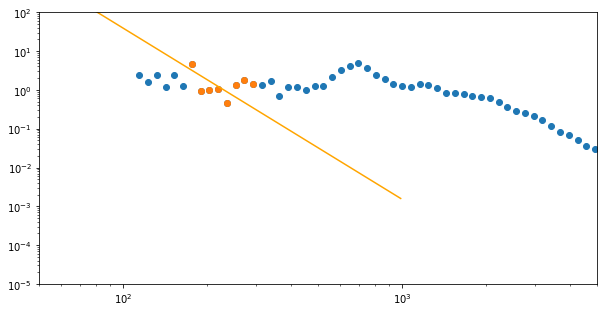

In [80]:
plt.figure(figsize = (10,5))
plt.scatter(radial_bin_centers, density_bin)
plt.scatter(radial_bin_centers2[0:8], density_bin2[0:8])

plt.plot(r, prof, color = 'orange')
# plt.scatter(radial_bin_centers[err], density_bin[err])
plt.xscale('log')
plt.yscale('log')
plt.xlim(5e1,5e3)
plt.ylim(1e-5, 1e2)

In [47]:
cat['gas_gamma'][35]

-3.2231054207202265

In [ ]:
len(np.where(cat['star_gamma'] < 0.5)[0])

In [3]:
good = np.genfromtxt('illustris_data/good_mergers')

In [4]:
bad = np.genfromtxt('illustris_data/bad_mergers')

In [5]:
len(good)

20351

In [6]:
len(bad)
# bad

3720

# create extra data

In [ ]:
list_bh_mdot_out = []
stranges = []

In [ ]:
#iteration
# i = 0

for i in range(15657, len(cat)):
    print(i, end = ' ')
    #merger index
    merger_index = cat['merger'][i]


    f = h5py.File(path + bh_out[i])

    bh_id_out = int(cat['id_new_fin_out'][i])
    bh_id_out_old = int(cat['id_old_fin_out'][i])
    
    if len(f['PartType5']['ParticleIDs'][:]) == 1:
        f_index = np.array([0])
    else:
    
        f_index = np.where(f['PartType5']['ParticleIDs'][:] == bh_id_out)[0]    
        if len(f_index)  == 0:
            f_index = np.where(f['PartType5']['ParticleIDs'][:] == bh_id_out_old)[0]
            if len(f_index) == 0:
                mass_abs = np.abs(np.log(f['PartType5']['BH_Mass'][:]* 1e10/h / cat[i]['mass_new_fin_out']))
                f_index = np.where(mass_abs == min(mass_abs))[0]
                stranges.append(i)
            

    #accretion rate
    bh_mdot_out = f['PartType5']['BH_Mdot'][f_index][0]* 10.22
    
    #add list
    list_bh_mdot_out.append(bh_mdot_out)

In [ ]:
np.save('illustris_data/mask',np.array(stranges))

In [ ]:
mask = np.load('illustris_data/mask.npy')

In [ ]:
final_name = 'illustris_data/bh_mdot_out.txt'
tabs = 'bh_mdot_out\n'

In [ ]:
with open(final_name, 'w') as f:
    f.write(tabs)
    
    for i in range(len(cat)):
        f.write(str(list_bh_mdot_out[i]) + '\n')

In [ ]:
# final_name = 'illustris_data/final_catalog.txt'
# final_name = 'illustris_data/final_catalog2.txt'
final_name = 'illustris_data/final_catalog1.txt'

tabs = 'redshift\tsnap_in1\tsnap_in2\tsnap_out\tseparation\tv_disp_in1\t\
    v_disp_in2\tv_disp_out\tbh_mass_in1\tbh_mass_in2\tbh_mass_out\tbh_mdot_in1\t\
    bh_mdot_in2\tbh_mdot_out\tstellar_mass_in1\tstellar_mass_in2\tstellar_mass_out\t\
    total_mass_in1\ttotal_mass_in2\ttotal_mass_out\tgas_norm\tgas_gamma\t\
    stellar_norm\tstellar_gamma\tdm_norm\tdm_gamma\n'

total_list = []
for i in range(1):
# for i in range(10):
    one_list = []
    one_list.append(list_redshift[i])

    one_list.append(list_snap_in1[i])
    one_list.append(list_snap_in2[i])
    one_list.append(list_snap_out[i])
    
    one_list.append(list_separation[i])
    
    one_list.append(list_v_disp_in1[i])
    one_list.append(list_v_disp_in2[i])
    one_list.append(list_v_disp_out[i])
    
    one_list.append(list_bh_mass_in1[i])
    one_list.append(list_bh_mass_in2[i])
    one_list.append(list_bh_mass_out[i])

    one_list.append(list_bh_mdot_in1[i])
    one_list.append(list_bh_mdot_in2[i])
    one_list.append(list_bh_mdot_out[i])
    
    one_list.append(list_stellar_mass_in1[i])
    one_list.append(list_stellar_mass_in2[i])
    one_list.append(list_stellar_mass_out[i])

    one_list.append(list_total_mass_in1[i])
    one_list.append(list_total_mass_in2[i])
    one_list.append(list_total_mass_out[i])

    one_list.append(list_gas_norm[i])
    one_list.append(list_gas_gamma[i])

    one_list.append(list_stellar_norm[i])
    one_list.append(list_stellar_gamma[i])

    one_list.append(list_dm_norm[i])
    one_list.append(list_dm_gamma[i])
    
    total_list.append(one_list)


In [ ]:
list_bh_v_in1 = []
list_bh_v_in2 = []

# lib_bh_m_in1 = []
# lib_bh_m_in2 = []
# lib_bh_m_out = []

list_bh_mdot_in1 = []
list_bh_mdot_in2 = []
list_bh_mdot_out = []

list_separation = []

In [ ]:
# for i in range(0, len(cat)):
stranges = []
for i in range(len(cat)):
# for i in range(len(cat)):
    print(i, end = ' ')
    #merger index
    merger_index = cat['merger'][i]

    f1 = h5py.File(path + bh_in[i])
    f2 = h5py.File(path + bh_in2[i])
#     f3 = h5py.File(path + bh_out[i])
    #id
    
    bh_id_in1 = int(cat['id_new_prev_in'][i])
    bh_id_in2 = int(cat['id_new_prev_out'][i])
    old_id_in1 = int(cat['id_old_prev_in'][i])
    old_id_in2 = int(cat['id_old_prev_out'][i])
    
#     total_ids = np.array([])

    #new ids match
    bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == bh_id_in1)[0]
    bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == bh_id_in2)[0]           
    
    if len(f1['PartType5']['ParticleIDs'][:]) == 1:
        bh_index_in1 = np.array([0])
    if len(f2['PartType5']['ParticleIDs'][:]) == 1:
        bh_index_in2 = np.array([0])
    
    
    if len(bh_index_in1) == 1 and len(bh_index_in2) == 0: #if they are old 
        print('index2 is strange')
        
        ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
        ans_mdot = cat['mdot_sum'][i]

        mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
        bh_index_in2 = np.array([mdot_index])
        
        if len(bh_index_in2) == 0:
            print('not solved')
            stranges.append(i)
        else:
            print('solved')
            stranges.append(i)

            
    elif len(bh_index_in1) == 0 and len(bh_index_in2) == 1:
        print('index1 is strange')
        
        ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
        ans_mdot = cat['mdot_sum'][i]

        mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
        bh_index_in1 = np.array([mdot_index])
        
        if len(bh_index_in1) == 0:
            print('not solved')
            stranges.append(i)
        else:
            print('solved')
            stranges.append(i)
            
    elif len(bh_index_in1) == 0 and len(bh_index_in2) == 0:
        #switch
        print('try switch')
        bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == bh_id_in2)[0]
        bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == bh_id_in1)[0] 
        
        if len(bh_index_in1) == 1 and len(bh_index_in2) == 0:
            ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
            ans_mdot = cat['mdot_sum'][i]

            mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
            bh_index_in2 = np.array([mdot_index])
        
            if len(bh_index_in2) == 0:
                print('not solved')
                stranges.append(i)
            else:
                print('solved')
                stranges.append(i)
        
        elif len(bh_index_in1) == 0 and len(bh_index_in2) == 1:
            ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
            ans_mdot = cat['mdot_sum'][i]

            mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
            bh_index_in1 = np.array([mdot_index])
            
            if len(bh_index_in1) == 0:
                print('not solved')
                stranges.append(i)
            else:
                print('solved')
                stranges.append(i)
            
        elif len(bh_index_in1) == 0 and len(bh_index_in2) == 0:
            print('again')
            bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == old_id_in1)[0]
            
            if len(bh_index_in1) == 0:
                bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == old_id_in2)[0]
                
                if len(bh_index_in1) == 0:
                    bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == old_id_in1)[0]
                    
                    if len(bh_index_in2) == 0:
                        bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == old_id_in2)[0]
                        
                        if len(bh_index_in2) == 0:
                            print('fail')
                        elif len(bh_index_in2) == 1:
                            ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
                            ans_mdot = cat['mdot_sum'][i]

                            mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                            bh_index_in1 = np.array([mdot_index])

                            if len(bh_index_in1) == 0:
                                print('not solved')
                                stranges.append(i)
                            else:
                                print('solved')
                                stranges.append(i)                            
                        
                    elif len(bh_index_in2) == 1:
                        ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
                        ans_mdot = cat['mdot_sum'][i]

                        mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                        bh_index_in1 = np.array([mdot_index])

                        if len(bh_index_in1) == 0:
                            print('not solved')
                            stranges.append(i)
                        else:
                            print('solved')
                            stranges.append(i)
                        
                elif len(bh_index_in1) == 1:
                    ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
                    ans_mdot = cat['mdot_sum'][i]

                    mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                    bh_index_in2 = np.array([mdot_index])

                    if len(bh_index_in2) == 0:
                        print('not solved')
                        stranges.append(i)
                    else:
                        print('solved')
                        stranges.append(i)
                    
                
                elif len(bh_index_in1) == 1:
                    ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
                    ans_mdot = cat['mdot_sum'][i]

                    mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                    bh_index_in2 = np.array([mdot_index])

                    if len(bh_index_in2) == 0:
                        print('not solved')
                        stranges.append(i)
                    else:
                        print('solved')
                        stranges.append(i)
              
            
            elif len(bh_index_in1) == 1:                
                ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
                ans_mdot = cat['mdot_sum'][i]

                mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                bh_index_in2 = np.array([mdot_index])

                if len(bh_index_in2) == 0:
                    print('not solved')
                    stranges.append(i)
                else:
                    print('solved')
                    stranges.append(i)
    else:
        print('success')
    
    #bh accretion
    bh_mdot_in1 = f1['PartType5']['BH_Mdot'][bh_index_in1][:] * 10.22
    bh_mdot_in2 = f2['PartType5']['BH_Mdot'][bh_index_in2][:] * 10.22
    
    bh_mdot_in1[0]
    bh_mdot_in1[0]
    
    #separation
    
    scale_in1 = f1['Header'].attrs['Time']
    scale_in2 = f2['Header'].attrs['Time']
    
    sep_in1 = f1['PartType5']['BH_Hsml'][bh_index_in1][:] * scale_in1 / h
    sep_in2 = f2['PartType5']['BH_Hsml'][bh_index_in2][:] * scale_in2 / h
    separation = np.max([sep_in1, sep_in2])
    
    #bh velocity
    bh_v_in1 =  f1['PartType5']['Velocities'][bh_index_in1][:]**2
    bh_v_in1 = np.sqrt(np.sum(bh_v_in1))

    #bh velocity
    bh_v_in2 =  f2['PartType5']['Velocities'][bh_index_in2][:]**2
    bh_v_in2 = np.sqrt(np.sum(bh_v_in2))
    
    #add list
    list_bh_v_in1.append(bh_v_in1)
    list_bh_v_in2.append(bh_v_in2)
    
    
    list_bh_mdot_in1.append(bh_mdot_in1[0])
    list_bh_mdot_in2.append(bh_mdot_in2[0])
#     list_bh_mdot_out.append(bh_mdot_out)

    list_separation.append(separation)

In [ ]:
list_bh_v_x_in1 = []
list_bh_v_y_in1 = []
list_bh_v_z_in1 = []

list_bh_v_x_in2 = []
list_bh_v_y_in2 = []
list_bh_v_z_in2 = []

In [ ]:
# for i in range(0, len(cat)):
stranges = []
for i in range(len(cat)):
# for i in range(len(cat)):
    print(i, end = ' ')
    #merger index
    merger_index = cat['merger'][i]

    f1 = h5py.File(path + bh_in[i])
    f2 = h5py.File(path + bh_in2[i])
#     f3 = h5py.File(path + bh_out[i])
    #id
    
    bh_id_in1 = int(cat['id_new_prev_in'][i])
    bh_id_in2 = int(cat['id_new_prev_out'][i])
    old_id_in1 = int(cat['id_old_prev_in'][i])
    old_id_in2 = int(cat['id_old_prev_out'][i])
    
#     total_ids = np.array([])

    #new ids match
    bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == bh_id_in1)[0]
    bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == bh_id_in2)[0]           
    
    if len(f1['PartType5']['ParticleIDs'][:]) == 1:
        bh_index_in1 = np.array([0])
    if len(f2['PartType5']['ParticleIDs'][:]) == 1:
        bh_index_in2 = np.array([0])
    
    
    if len(bh_index_in1) == 1 and len(bh_index_in2) == 0: #if they are old 
        print('index2 is strange')
        
        ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
        ans_mdot = cat['mdot_sum'][i]

        mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
        bh_index_in2 = np.array([mdot_index])
        
        if len(bh_index_in2) == 0:
            print('not solved')
            stranges.append(i)
        else:
            print('solved')
            stranges.append(i)

            
    elif len(bh_index_in1) == 0 and len(bh_index_in2) == 1:
        print('index1 is strange')
        
        ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
        ans_mdot = cat['mdot_sum'][i]

        mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
        bh_index_in1 = np.array([mdot_index])
        
        if len(bh_index_in1) == 0:
            print('not solved')
            stranges.append(i)
        else:
            print('solved')
            stranges.append(i)
            
    elif len(bh_index_in1) == 0 and len(bh_index_in2) == 0:
        #switch
        print('try switch')
        bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == bh_id_in2)[0]
        bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == bh_id_in1)[0] 
        
        if len(bh_index_in1) == 1 and len(bh_index_in2) == 0:
            ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
            ans_mdot = cat['mdot_sum'][i]

            mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
            bh_index_in2 = np.array([mdot_index])
        
            if len(bh_index_in2) == 0:
                print('not solved')
                stranges.append(i)
            else:
                print('solved')
                stranges.append(i)
        
        elif len(bh_index_in1) == 0 and len(bh_index_in2) == 1:
            ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
            ans_mdot = cat['mdot_sum'][i]

            mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
            bh_index_in1 = np.array([mdot_index])
            
            if len(bh_index_in1) == 0:
                print('not solved')
                stranges.append(i)
            else:
                print('solved')
                stranges.append(i)
            
        elif len(bh_index_in1) == 0 and len(bh_index_in2) == 0:
            print('again')
            bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == old_id_in1)[0]
            
            if len(bh_index_in1) == 0:
                bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == old_id_in2)[0]
                
                if len(bh_index_in1) == 0:
                    bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == old_id_in1)[0]
                    
                    if len(bh_index_in2) == 0:
                        bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == old_id_in2)[0]
                        
                        if len(bh_index_in2) == 0:
                            print('fail')
                        elif len(bh_index_in2) == 1:
                            ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
                            ans_mdot = cat['mdot_sum'][i]

                            mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                            bh_index_in1 = np.array([mdot_index])

                            if len(bh_index_in1) == 0:
                                print('not solved')
                                stranges.append(i)
                            else:
                                print('solved')
                                stranges.append(i)                            
                        
                    elif len(bh_index_in2) == 1:
                        ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
                        ans_mdot = cat['mdot_sum'][i]

                        mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                        bh_index_in1 = np.array([mdot_index])

                        if len(bh_index_in1) == 0:
                            print('not solved')
                            stranges.append(i)
                        else:
                            print('solved')
                            stranges.append(i)
                        
                elif len(bh_index_in1) == 1:
                    ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
                    ans_mdot = cat['mdot_sum'][i]

                    mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                    bh_index_in2 = np.array([mdot_index])

                    if len(bh_index_in2) == 0:
                        print('not solved')
                        stranges.append(i)
                    else:
                        print('solved')
                        stranges.append(i)
                    
                
                elif len(bh_index_in1) == 1:
                    ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
                    ans_mdot = cat['mdot_sum'][i]

                    mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                    bh_index_in2 = np.array([mdot_index])

                    if len(bh_index_in2) == 0:
                        print('not solved')
                        stranges.append(i)
                    else:
                        print('solved')
                        stranges.append(i)
              
            
            elif len(bh_index_in1) == 1:                
                ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
                ans_mdot = cat['mdot_sum'][i]

                mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
                bh_index_in2 = np.array([mdot_index])

                if len(bh_index_in2) == 0:
                    print('not solved')
                    stranges.append(i)
                else:
                    print('solved')
                    stranges.append(i)
    else:
        print('success')

    #bh velocity
    bh_v_in1 =  f1['PartType5']['Velocities'][bh_index_in1][:]
    bh_v_x_in1 = bh_v_in1[0][0]
    bh_v_y_in1 = bh_v_in1[0][1]
    bh_v_z_in1 = bh_v_in1[0][2]

    #bh velocity
    bh_v_in2 =  f2['PartType5']['Velocities'][bh_index_in2][:]**2
    bh_v_x_in2 = bh_v_in2[0][0]
    bh_v_y_in2 = bh_v_in2[0][1]
    bh_v_z_in2 = bh_v_in2[0][2]

    
    #add list
    list_bh_v_x_in1.append(bh_v_x_in1)
    list_bh_v_y_in1.append(bh_v_y_in1)
    list_bh_v_z_in1.append(bh_v_z_in1)
    
    list_bh_v_x_in2.append(bh_v_x_in2)
    list_bh_v_y_in2.append(bh_v_y_in2)
    list_bh_v_z_in2.append(bh_v_z_in2)
    

In [ ]:
final_name = 'illustris_data/velocities.txt'

tabs = 'bh_v_x_in1\tbh_v_y_in1\tbh_b_v_in1\tbh_v_x_in2\tbh_v_y_in2\tbh_v_z_in2\n'

total_list = []
for i in range(len(cat)):
# for i in range(10):
    one_list = []
    one_list.append(list_bh_v_x_in1[i])
    one_list.append(list_bh_v_y_in1[i])
    one_list.append(list_bh_v_z_in1[i])
    one_list.append(list_bh_v_x_in2[i])
    one_list.append(list_bh_v_y_in2[i])
    one_list.append(list_bh_v_z_in2[i])
    
    total_list.append(one_list)

In [ ]:
with open(final_name, 'w') as f:
    f.write(tabs)
    
    for i in range(len(cat)):
        for total in total_list[i]:
            f.write(str(total) + '\t')
        f.write('\n')

In [ ]:
# 10^6 cut
# m_num = []
# stranges = []
# for i in range(len(cat)):
# # for i in range(len(cat)):
#     print(i, end = ' ')
#     #merger index
#     merger_index = cat['merger'][i]

#     f1 = h5py.File(path + bh_in[i])
#     f2 = h5py.File(path + bh_in2[i])
# #     f3 = h5py.File(path + bh_out[i])
#     #id
    
#     bh_id_in1 = int(cat['id_new_prev_in'][i])
#     bh_id_in2 = int(cat['id_new_prev_out'][i])
#     old_id_in1 = int(cat['id_old_prev_in'][i])
#     old_id_in2 = int(cat['id_old_prev_out'][i])
    
# #     total_ids = np.array([])

#     #new ids match
#     bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == bh_id_in1)[0]
#     bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == bh_id_in2)[0]           
    
#     if len(f1['PartType5']['ParticleIDs'][:]) == 1:
#         bh_index_in1 = np.array([0])
#     if len(f2['PartType5']['ParticleIDs'][:]) == 1:
#         bh_index_in2 = np.array([0])
    
    
#     if len(bh_index_in1) == 1 and len(bh_index_in2) == 0: #if they are old 
#         print('index2 is strange')
        
#         ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
#         ans_mdot = cat['mdot_sum'][i]

#         mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#         bh_index_in2 = np.array([mdot_index])
        
#         if len(bh_index_in2) == 0:
#             print('not solved')
#             stranges.append(i)
#         else:
#             print('solved')
#             stranges.append(i)

            
#     elif len(bh_index_in1) == 0 and len(bh_index_in2) == 1:
#         print('index1 is strange')
        
#         ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
#         ans_mdot = cat['mdot_sum'][i]

#         mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#         bh_index_in1 = np.array([mdot_index])
        
#         if len(bh_index_in1) == 0:
#             print('not solved')
#             stranges.append(i)
#         else:
#             print('solved')
#             stranges.append(i)
            
#     elif len(bh_index_in1) == 0 and len(bh_index_in2) == 0:
#         #switch
#         print('try switch')
#         bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == bh_id_in2)[0]
#         bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == bh_id_in1)[0] 
        
#         if len(bh_index_in1) == 1 and len(bh_index_in2) == 0:
#             ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
#             ans_mdot = cat['mdot_sum'][i]

#             mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#             bh_index_in2 = np.array([mdot_index])
        
#             if len(bh_index_in2) == 0:
#                 print('not solved')
#                 stranges.append(i)
#             else:
#                 print('solved')
#                 stranges.append(i)
        
#         elif len(bh_index_in1) == 0 and len(bh_index_in2) == 1:
#             ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
#             ans_mdot = cat['mdot_sum'][i]

#             mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#             bh_index_in1 = np.array([mdot_index])
            
#             if len(bh_index_in1) == 0:
#                 print('not solved')
#                 stranges.append(i)
#             else:
#                 print('solved')
#                 stranges.append(i)
            
#         elif len(bh_index_in1) == 0 and len(bh_index_in2) == 0:
#             print('again')
#             bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == old_id_in1)[0]
            
#             if len(bh_index_in1) == 0:
#                 bh_index_in1 = np.where(f1['PartType5']['ParticleIDs'][:] == old_id_in2)[0]
                
#                 if len(bh_index_in1) == 0:
#                     bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == old_id_in1)[0]
                    
#                     if len(bh_index_in2) == 0:
#                         bh_index_in2 = np.where(f2['PartType5']['ParticleIDs'][:] == old_id_in2)[0]
                        
#                         if len(bh_index_in2) == 0:
#                             print('fail')
#                         elif len(bh_index_in2) == 1:
#                             ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
#                             ans_mdot = cat['mdot_sum'][i]

#                             mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#                             bh_index_in1 = np.array([mdot_index])

#                             if len(bh_index_in1) == 0:
#                                 print('not solved')
#                                 stranges.append(i)
#                             else:
#                                 print('solved')
#                                 stranges.append(i)                            
                        
#                     elif len(bh_index_in2) == 1:
#                         ex_mdot = (f1['PartType5']['BH_Mdot'][:] + f2['PartType5']['BH_Mdot'][:][bh_index_in2]) * 10.22
#                         ans_mdot = cat['mdot_sum'][i]

#                         mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#                         bh_index_in1 = np.array([mdot_index])

#                         if len(bh_index_in1) == 0:
#                             print('not solved')
#                             stranges.append(i)
#                         else:
#                             print('solved')
#                             stranges.append(i)
                        
#                 elif len(bh_index_in1) == 1:
#                     ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
#                     ans_mdot = cat['mdot_sum'][i]

#                     mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#                     bh_index_in2 = np.array([mdot_index])

#                     if len(bh_index_in2) == 0:
#                         print('not solved')
#                         stranges.append(i)
#                     else:
#                         print('solved')
#                         stranges.append(i)
                    
                
#                 elif len(bh_index_in1) == 1:
#                     ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
#                     ans_mdot = cat['mdot_sum'][i]

#                     mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#                     bh_index_in2 = np.array([mdot_index])

#                     if len(bh_index_in2) == 0:
#                         print('not solved')
#                         stranges.append(i)
#                     else:
#                         print('solved')
#                         stranges.append(i)
              
            
#             elif len(bh_index_in1) == 1:                
#                 ex_mdot = (f1['PartType5']['BH_Mdot'][:][bh_index_in1] + f2['PartType5']['BH_Mdot'][:]) * 10.22
#                 ans_mdot = cat['mdot_sum'][i]

#                 mdot_index = np.argmin(np.abs(ex_mdot - ans_mdot))
#                 bh_index_in2 = np.array([mdot_index])

#                 if len(bh_index_in2) == 0:
#                     print('not solved')
#                     stranges.append(i)
#                 else:
#                     print('solved')
#                     stranges.append(i)
#     else:
#         print('success')

#     #bh velocity
#     bh_mass_in1 =  f1['PartType5']['BH_Mass'][bh_index_in1][:]* 1e10/h

#     #bh velocity
#     bh_mass_in2 =  f2['PartType5']['BH_Mass'][bh_index_in2][:] * 1e10/h

#     if (bh_mass_in1 >=  1e6) & (bh_mass_in2 >= 1e6):

#         m_num.append(i)

    

In [ ]:
# np.where(cat['merger'])
new = cat[m_num]

In [ ]:
new = new.to_pandas()

In [ ]:
new.to_csv('new.txt')

In [ ]:
temp = cat['separation'][:] / tot['separation']

In [ ]:
# tot['separation']

In [ ]:
np.where((temp > 1.1) | (temp < 0.9))[0]

In [ ]:
final_name = 'illustris_data/extra_catalog.txt'

tabs = 'bh_v_in1\tbh_v_in2\tbh_mdot_in1\tbh_mdot_in2\tseparation\n'

total_list = []
for i in range(len(cat)):
# for i in range(10):
    one_list = []
    one_list.append(list_bh_v_in1[i])
    one_list.append(list_bh_v_in2[i])
    one_list.append(list_bh_mdot_in1[i])
    one_list.append(list_bh_mdot_in2[i])
    one_list.append(list_separation[i])
    
    total_list.append(one_list)

In [ ]:
with open(final_name, 'w') as f:
    f.write(tabs)
    
    for i in range(len(cat)):
        for total in total_list[i]:
            f.write(str(total) + '\t')
        f.write('\n')

In [ ]:
ex = ascii.read('illustris_data/catalog.txt')

In [ ]:
tot = ascii.read(final_name)
tot

In [ ]:
final_redshift = ex['redshift']

final_snap_in1 = ex['snap_in1']
final_snap_in2 = ex['snap_in2']
final_snap_out = ex['snap_out']

final_bh_mass_in1 = ex['bh_mass_in1']
final_bh_mass_in2 = ex['bh_mass_in2']

final_bh_mdot_in1 = tot['bh_mdot_in1']
final_bh_mdot_in2 = tot['bh_mdot_in2']

final_bh_v_in1 = tot['bh_v_in1']
final_bh_v_in2 = tot['bh_v_in2']

final_separation = tot['separation']

final_stellar_vdisp_in1 = ex['v_disp_in1']
final_stellar_vdisp_in2 = ex['v_disp_in2']
final_stellar_vdisp_out = ex['v_disp_out']

final_stellar_mass_in1 = ex['stellar_mass_in1']
final_stellar_mass_in2 = ex['stellar_mass_in2']
final_stellar_mass_out = ex['stellar_mass_out']

final_total_mass_in1 = ex['total_mass_in1']
final_total_mass_in2 = ex['total_mass_in2']
final_total_mass_out = ex['total_mass_out']

final_gas_norm = ex['gas_norm']
final_gas_gamma = ex['gas_gamma']

final_stellar_norm = ex['stellar_norm']
final_stellar_gamma = ex['stellar_gamma']

final_dm_norm = ex['dm_norm']
final_dm_gamma = ex['dm_gamma']

In [ ]:
tabs = 'redshift\tsnap_in1\tsnap_in2\tsnap_out\tbh_mass_in1\tbh_mass_in2\tbh_mdot_in1\tbh_mdot_in2\tbh_v_in1\tbh_v_in2\tseparation\tstellar_vdisp_in1\tstellar_vdisp_in2\tstellar_vdisp_out\tstellar_mass_in1\tstellar_mass_in2\tstellar_mass_out\ttotal_mass_in1\ttotal_mass_in2\ttotal_mass_out\tgas_norm\tgas_gamma\tstellar_norm\tstellar_gamma\tdm_norm\tdm_gamma\n'

total_list = []
for i in range(len(cat)):
# for i in range(10):
    one_list = []
    one_list.append(final_redshift[i])
    
    one_list.append(final_snap_in1[i])
    one_list.append(final_snap_in2[i])
    one_list.append(final_snap_out[i])
    
    one_list.append(final_bh_mass_in1[i])
    one_list.append(final_bh_mass_in2[i])
    
    one_list.append(final_bh_mdot_in1[i])
    one_list.append(final_bh_mdot_in2[i])
    
    one_list.append(final_bh_v_in1[i])
    one_list.append(final_bh_v_in2[i])
    
    one_list.append(final_separation[i])

    one_list.append(final_stellar_vdisp_in1[i])
    one_list.append(final_stellar_vdisp_in2[i])
    one_list.append(final_stellar_vdisp_out[i])
    
    one_list.append(final_stellar_mass_in1[i])
    one_list.append(final_stellar_mass_in2[i])
    one_list.append(final_stellar_mass_out[i])
    
    one_list.append(final_total_mass_in1[i])
    one_list.append(final_total_mass_in2[i])
    one_list.append(final_total_mass_out[i])
    
    one_list.append(final_gas_norm[i])
    one_list.append(final_gas_gamma[i])
    one_list.append(final_stellar_norm[i])
    one_list.append(final_stellar_gamma[i])
    one_list.append(final_dm_norm[i])
    one_list.append(final_dm_gamma[i])
    total_list.append(one_list)

# final subhalo download

In [ ]:
with open('illustris_data/data.txt', 'w') as f:
    f.write(tabs)
    
    for i in range(len(total_list)):
        for j in range(len(total_list[i])):
            f.write(str(total_list[i][j]) + '\t')
        f.write('\n')

In [ ]:
path = 'illustris_data/final/'
file_list = os.listdir(path)

In [ ]:
for i in range(0,50):
    print(i, end = ' ')
    cutout_request = {
        'bhs': 'all',
        'gas': 'Coordinates,Masses,Velocities,StarFormationRate',
        'stars': 'Coordinates,Masses,Velocities,GFM_StellarFormationTime',
        'dm': 'Coordinates,Velocities'
    }
    
    snap = extra2[i].split('_')[1]
    sub = extra2[i].split('_')[2][:-5]
    
    cutout = get('http://www.illustris-project.org/api/Illustris-1/snapshots/'+ snap +'/subhalos/'+sub+'/cutout.hdf5', cutout_request)
    
    path = 'illustris_data/final/extra/cutout_' + snap + '_' + sub + '.hdf5'
    
    with open(path, 'wb') as f:
        f.write(cutout.content)